In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder

from imblearn.over_sampling import SMOTE
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.utils import plot_model

import time
import warnings
warnings.filterwarnings("ignore")

### Data Loading and Pre-processing

In [2]:
dataset = pd.read_csv("DatasetDiabetes.csv")

In [3]:
dataset.head()

,ID,No_Pation,Gender,AGE,Urea,Cr,HbA1c,Chol,TG,HDL,LDL,VLDL,BMI,CLASS
0,502,17975,F,50,4.7,46,4.9,4.2,0.9,2.4,1.4,0.5,24.0,N
1,735,34221,M,26,4.5,62,4.9,3.7,1.4,1.1,2.1,0.6,23.0,N
2,420,47975,F,50,4.7,46,4.9,4.2,0.9,2.4,1.4,0.5,24.0,N
3,680,87656,F,50,4.7,46,4.9,4.2,0.9,2.4,1.4,0.5,24.0,N
4,504,34223,M,33,7.1,46,4.9,4.9,1.0,0.8,2.0,0.4,21.0,N


In [7]:
dataset = dataset.drop(columns=['ID', 'No_Pation'])

In [9]:
dataset.head()

,Gender,AGE,Urea,Cr,HbA1c,Chol,TG,HDL,LDL,VLDL,BMI,CLASS
0,F,50,4.7,46,4.9,4.2,0.9,2.4,1.4,0.5,24.0,N
1,M,26,4.5,62,4.9,3.7,1.4,1.1,2.1,0.6,23.0,N
2,F,50,4.7,46,4.9,4.2,0.9,2.4,1.4,0.5,24.0,N
3,F,50,4.7,46,4.9,4.2,0.9,2.4,1.4,0.5,24.0,N
4,M,33,7.1,46,4.9,4.9,1.0,0.8,2.0,0.4,21.0,N


In [11]:
#Check the total percentage of missing values 
missing_values_count= dataset.isnull().sum()
total_cells = np.product(dataset.shape)
total_missing = missing_values_count.sum()

# Missing data percentage
print(f"Percentage of total missing cells in the data {(total_missing/total_cells) * 100}%")
print(dataset.isnull().sum())

Percentage of total missing cells in the data 0.0%
Gender    0
AGE       0
Urea      0
Cr        0
HbA1c     0
Chol      0
TG        0
HDL       0
LDL       0
VLDL      0
BMI       0
CLASS     0
dtype: int64


In [13]:

dataset['Gender'] = dataset['Gender'].map({'M': 0, 'F': 1})

In [15]:
dataset.head()

,Gender,AGE,Urea,Cr,HbA1c,Chol,TG,HDL,LDL,VLDL,BMI,CLASS
0,1,50,4.7,46,4.9,4.2,0.9,2.4,1.4,0.5,24.0,N
1,0,26,4.5,62,4.9,3.7,1.4,1.1,2.1,0.6,23.0,N
2,1,50,4.7,46,4.9,4.2,0.9,2.4,1.4,0.5,24.0,N
3,1,50,4.7,46,4.9,4.2,0.9,2.4,1.4,0.5,24.0,N
4,0,33,7.1,46,4.9,4.9,1.0,0.8,2.0,0.4,21.0,N


In [17]:
dataset['Gender'].value_counts()

Gender
0    565
1    435
Name: count, dtype: int64

In [19]:
dataset['CLASS'].value_counts()

CLASS
Y     840
N     102
P      53
Y       4
N       1
Name: count, dtype: int64

In [21]:
dataset['CLASS'] = (
    dataset['CLASS']
    .astype(str)
    .str.strip()     # removes trailing/leading spaces
    .str.upper()     # standardize case
)

In [23]:
dataset = dataset[dataset['CLASS'].isin(['Y', 'N', 'P'])]

In [25]:
print(dataset['CLASS'].value_counts())
print(dataset['CLASS'].unique())

CLASS
Y    844
N    103
P     53
Name: count, dtype: int64
['N' 'P' 'Y']


<Axes: xlabel='CLASS', ylabel='count'>

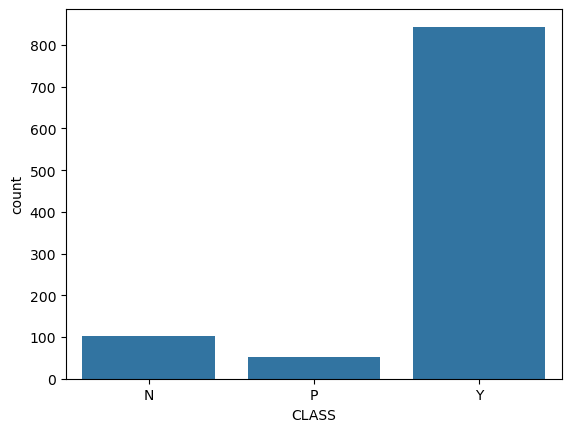

In [27]:
sns.countplot(x=dataset['CLASS'])

In [29]:
# Separating features (X) and target variables (Y)
X = dataset.drop(columns=['CLASS'])
Y = dataset['CLASS']

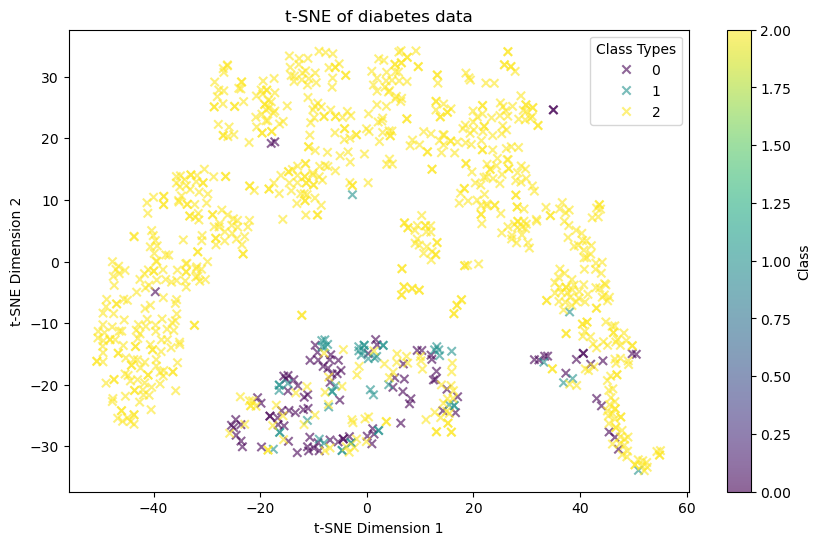

In [31]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=42, perplexity=30)
X_tsne = tsne.fit_transform(X)

plt.figure(figsize=(10, 6))
scatter = plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=Y.astype("category").cat.codes, cmap="viridis", alpha=0.6, marker='x')
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.title("t-SNE of diabetes data")
plt.legend(*scatter.legend_elements(), title="Class Types")
plt.colorbar(label="Class")
plt.show()

In [32]:
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(Y)

### Data Splitting

In [33]:
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42,stratify=y_encoded)

### Data Scaling

In [37]:
# Scale (both train and test)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [39]:
import joblib
joblib.dump(scaler, "scaler.pkl")

['scaler.pkl']

### Data Balancing

In [41]:
# training set only
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline

smote = SMOTE(random_state=42, k_neighbors=4)
X_train, y_train = smote.fit_resample(X_train, y_train)

In [43]:
print(y_train.dtype)


int32


In [45]:
# Convert y_train_multi_smote to a pandas Series
y_train_smote_series = pd.Series(y_train)
y_train_smote_series = pd.Series(y_train)

print("Balanced Class Distribution (Training Set Only):")
print(y_train_smote_series.value_counts())
print()
print(y_train_smote_series.value_counts())

Balanced Class Distribution (Training Set Only):
2    675
0    675
1    675
Name: count, dtype: int64

2    675
0    675
1    675
Name: count, dtype: int64


In [47]:
np.unique(y_train, return_counts=True)

(array([0, 1, 2]), array([675, 675, 675], dtype=int64))

### Model training and testing

In [49]:
model = Sequential()
model.add(Dense(128, activation='relu', input_dim=X_train.shape[1]))
model.add(Dense(64, activation='relu'))
model.add(Dense(len(label_encoder.classes_), activation='softmax'))
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

Start_time1 = time.time()
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.2)
end_time1 = time.time()


Epoch 1/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.6701 - loss: 0.8445 - val_accuracy: 0.1654 - val_loss: 1.1535
Epoch 2/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8383 - loss: 0.3852 - val_accuracy: 0.5185 - val_loss: 0.8606
Epoch 3/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8824 - loss: 0.3004 - val_accuracy: 0.7926 - val_loss: 0.5807
Epoch 4/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9422 - loss: 0.2137 - val_accuracy: 0.8914 - val_loss: 0.4387
Epoch 5/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9553 - loss: 0.1715 - val_accuracy: 0.9358 - val_loss: 0.2952
Epoch 6/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9680 - loss: 0.1315 - val_accuracy: 0.9309 - val_loss: 0.2770
Epoch 7/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9676 - loss: 0.1333 - val_accuracy: 0.9778 - val_loss: 0.1735
Epoch 8/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9774 - loss: 0.0962 - val_accuracy: 0.9654 - v

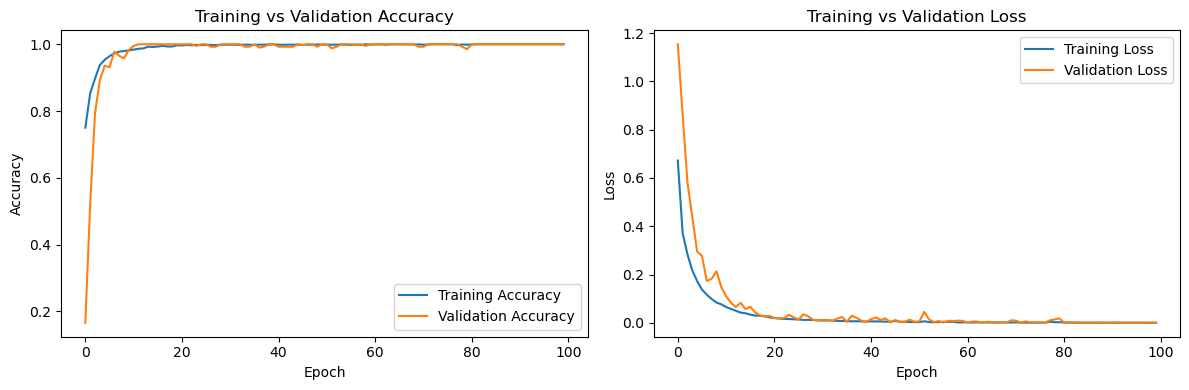

In [50]:
# Plotting function
def plot_training_history(history):
    plt.figure(figsize=(12, 4))
    
    # Plot Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Training vs Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    
    # Plot Loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Training vs Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

plot_training_history(history)

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


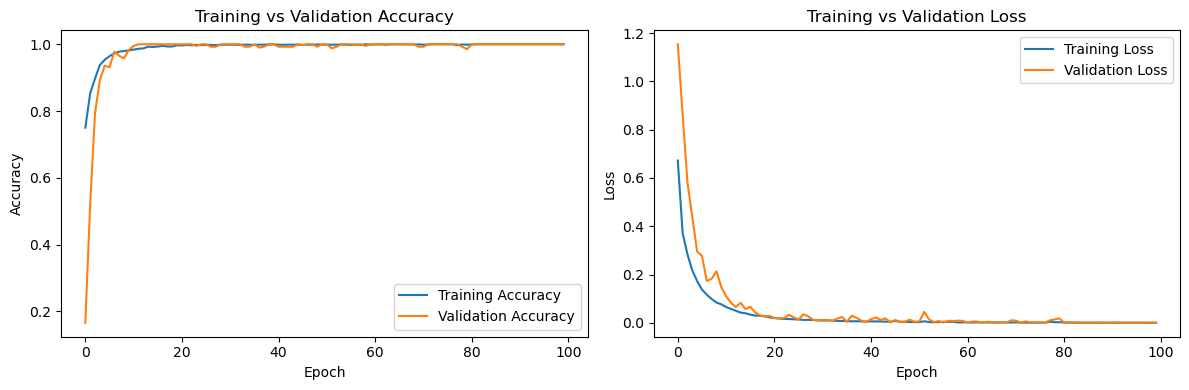

==============================  Model performance against faults ==============================
              precision    recall  f1-score   support

           N       0.90      0.86      0.88        21
           P       0.80      0.80      0.80        10
           Y       0.99      0.99      0.99       169

    accuracy                           0.97       200
   macro avg       0.90      0.88      0.89       200
weighted avg       0.97      0.97      0.97       200

==============================  Model Overall Results ==============================

Model Accuracy:  0.9700
Model Precision: 0.8961
Model Recall:    0.8837
Model F1 Score:  0.8897
Testing time:    0.1343



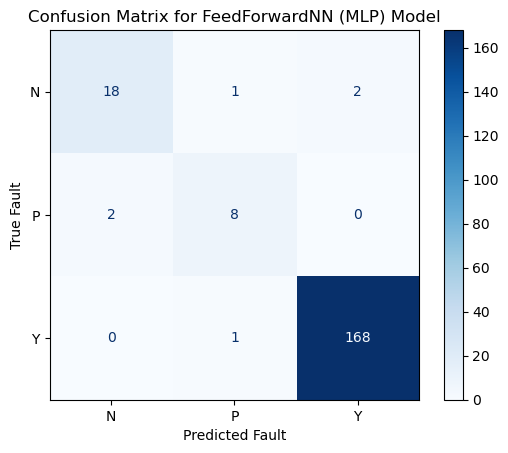

In [53]:
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, classification_report,ConfusionMatrixDisplay,\
                            precision_score, recall_score, f1_score, roc_auc_score,roc_curve,confusion_matrix

# Predict on new data
start_time = time.time()
y_pred = model.predict(X_test)  
y_pred_classes = np.argmax(y_pred, axis=1)  
end_time = time.time()

#Evalaution metrics
accuracy_test = accuracy_score(y_test,  y_pred_classes)
precision_test = precision_score(y_test, y_pred_classes, average = "macro")
recall_test = recall_score (y_test, y_pred_classes, average = "macro")
F1_score_test = f1_score (y_test, y_pred_classes, average = "macro")
cm = confusion_matrix(y_test, y_pred_classes)

# Plotting function
def plot_training_history(history):
    plt.figure(figsize=(12, 4))
    
    # Plot Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Training vs Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    
    # Plot Loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Training vs Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

plot_training_history(history)

print('==============================  Model performance against faults ==============================')
# Evaluation against the faults
print(classification_report(y_test, y_pred_classes, target_names= label_encoder.classes_))

print('==============================  Model Overall Results ==============================')
print()
print(f"Model Accuracy:  {accuracy_test:.4f}")
print(f"Model Precision: {precision_test:.4f}")
print(f"Model Recall:    {recall_test:.4f}")
print(f"Model F1 Score:  {F1_score_test:.4f}")
#print(f"Training time:    {end_time1 - start_time1:.4f}")
print(f"Testing time:    {end_time - start_time:.4f}")
print()
    
# Confusion matrix display for test results
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels= label_encoder.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.xlabel('Predicted Fault')
plt.ylabel('True Fault')
plt.title('Confusion Matrix for FeedForwardNN (MLP) Model')
plt.show()
print()

In [55]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 128)                 │           1,536 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 3)                   │             195 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 29,963 (117.05 KB)

 Trainable params: 9,987 (39.01 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 19,976 (78.04 KB)

In [57]:
model.save("diabetes_model.keras")